Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.optim
import torch.nn as nn
from torch.autograd import Variable

import utils
from model import create_model

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

sigma = 25
sigma_ = sigma/255.

In [2]:
fname = 'data/denoising/F16_GT.png'

# Load image

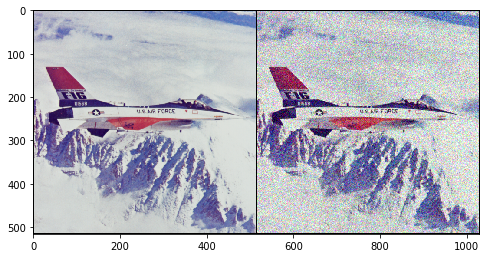

In [3]:
image = utils.get_image(fname)
img_pil = utils.crop_image(image, d=32)
img_np = utils.pil_to_np(img_pil)

_, img_noisy_np = utils.get_noisy_image(img_np, sigma_)

utils.plot_image_grid([img_np, img_noisy_np], 4, 6);

# Setup

In [4]:
INPUT = 'noise'
pad = 'zero'
OPT_OVER = 'net'

reg_noise_std = 1./30.
LR = 0.01

OPTIMIZER='adam'
show_every = 500

num_iter = 3000
input_depth = 32 
figsize = 4

net = create_model(downsample_channels = [8, 16, 32, 64, 128],
                    upsample_channels = [8, 16, 32, 64, 128],
                    skip_channels = [0, 0, 0, 4, 4],
                    input_channel_size = input_depth,
                    output_channel_size = 3,
                    upsample_mode='bilinear',
                    activation_function=nn.LeakyReLU(0.2, inplace=True),
                    padding_type=pad
                   )

net = net.type(dtype)
print("Model created")

net_input = utils.get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
# s = sum([np.prod(list(p.size())) for p in net.parameters()]); 
# print ('Number of params: %d' % s)

layer 0
layer 1
layer 2
layer 3
layer 4
Model created


# Optimize

Starting optimization with ADAM


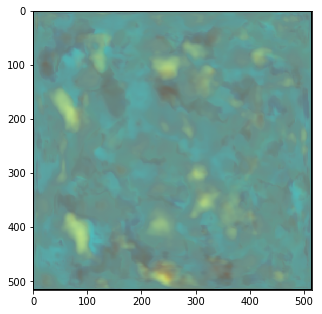

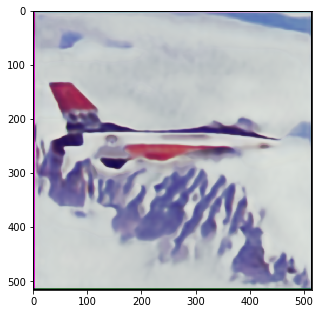

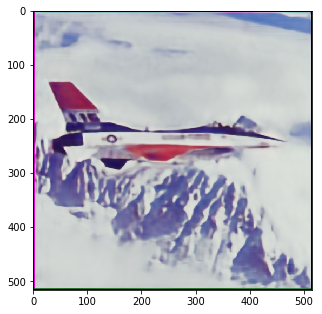

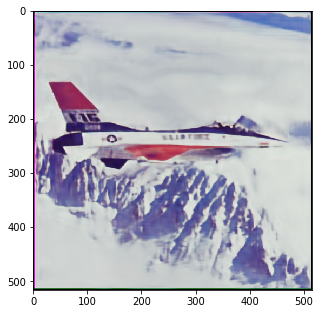

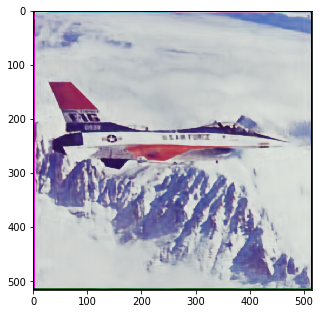

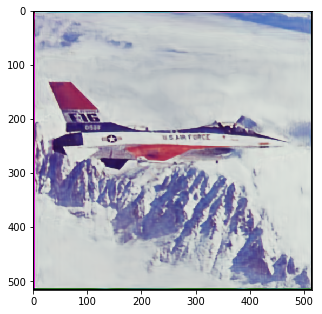

In [5]:
net_input_saved = net_input.data.clone()
noise = net_input.data.clone()

img_noisy_var = utils.np_to_var(img_noisy_np).type(dtype)

# Loss
mse = torch.nn.MSELoss().type(dtype)

i = 0
def closure():
    global i
    
    if reg_noise_std > 0:
        net_input.data = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    total_loss = mse(out, img_noisy_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.data[0]), '\r', end='')
    if  i % show_every == 0:
        out_np = utils.var_to_np(out)
        utils.plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

print('Starting optimization with ADAM')
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
        
for j in range(num_iter):
    optimizer.zero_grad()
    closure()
    optimizer.step()

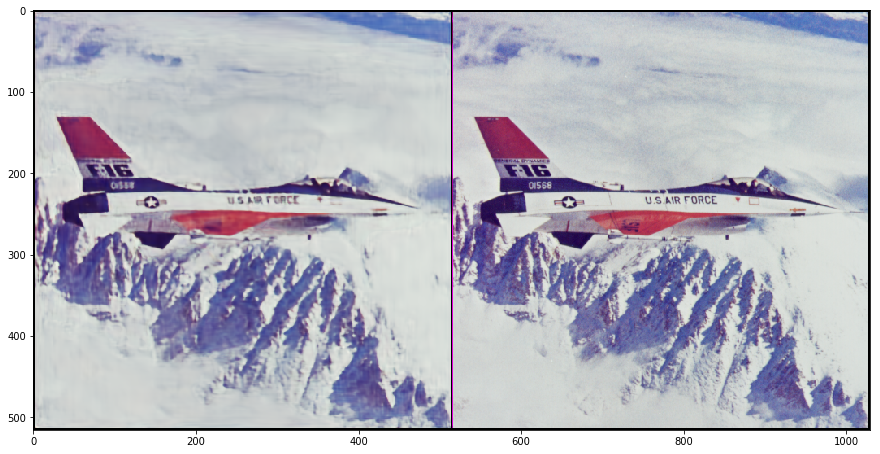

In [6]:
out_np = utils.var_to_np(net(net_input))
q = utils.plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);